# Result analytics

This notebook will load the result data from approaches and analyze the results and display charts

## Load Data

In [154]:
import pandas as pd
import numpy as np
import os
import gzip
import pickle
from glob import glob
from skimage.transform import resize
import matplotlib.pyplot as plt

folder = "/data/research/dwa_grid2"
#folder = "/results/test"

In [155]:
# load logs
logs = {}
task_names = None
#folder = "/results/res"  # DEBUG: stored in diff folder currently
for file in glob(os.path.join(folder, "*.gzip")):
    exp_name = os.path.splitext(os.path.splitext(os.path.basename(file))[0])[0]
    with gzip.open(file, 'rb') as log_file:
        log = pickle.load(log_file)
    logs[exp_name] = log
    if task_names is None:
        task_names = log["task_name"]
if task_names is None:
    task_names = dict((i, "task {}".format(i+1)) for i in range(100))
        
# load results
results = {}
for file in glob(os.path.join(folder, "*.txt")):
    exp_name = os.path.splitext(os.path.basename(file))[0]
    results[exp_name] = pd.DataFrame(np.loadtxt(file)).rename(columns=task_names)
    
# load results
analysis = {}
for file in glob(os.path.join(folder, "*.analysis")):
    exp_name, task_name = os.path.splitext(os.path.splitext(os.path.basename(file))[0])
    task_name = task_name.split('_')[1]
    exp_name = os.path.splitext(exp_name)[0]
    if exp_name not in analysis:
        analysis[exp_name] = {}
    with gzip.open(file, 'rb') as ana_file:
        data = pickle.load(ana_file)
    analysis[exp_name][task_name] = data

In [156]:
# show loaded experiments
print("Loaded Experiments ({}):".format(len(results)))
for exp in results:
    print("> {:30}{}{}".format(exp, " - has log data" if exp in logs else "", " - has analysis" if exp in analysis else ""))

Loaded Experiments (18):
> mixture_dwa_0_att_50          
> mixture_dwa_0_att_scaled       - has log data
> mixture_dwa_0_base             - has log data
> mixture_dwa_0_high_alpha       - has log data
> mixture_dwa_0_high_sparsity   
> mixture_dwa_0_long_warm        - has log data
> mixture_dwa_0_low_alpha        - has log data
> mixture_dwa_0_low_sparsity     - has log data
> mixture_dwa_0_no_triplet      
> mixture_dwa_0_no_warm          - has log data
> mixture_dwa_0_reg_01           - has log data
> mixture_dwa_0_reg_09           - has log data
> mixture_ewc_0_lam5000         
> mixture_ewc_0_lam50000         - has log data
> mixture_hat_0_base             - has log data
> mixture_joint_0_base          
> mixture_random_0_base         
> mixture_sgd_0_base             - has log data


## Plot Results

Plots results and relevant forgetting ratios

In [157]:
# define a name map (defines which objects should be loaded)
exp_map = {
    "mixture_dwa_0_base": "DWA Baseline",
    "mixture_dwa_0_emb100": "DWA 100 Embs",
    "mixture_dwa_0_exp_low_att": "DWA Low Attention [1,0.1]",
    "mixture_dwa_0_exp_high_att": "DWA High Attention [1,100]",
    "mixture_dwa_0_no_comb": "DWA Full Mask",
    "mixture_dwa_0_proc32-128": "DWA 32-128 Processor",
    "mixture_dwa_0_reg05": "DWA 0.5 Regression",
    "mixture_dwa_0_reg500": "DWA 500 Regression",
    "mixture_ewc_0_lam5000": "EWC 5000 Lambda",
    "mixture_sgd_0_base": "SGD",
    "mixture_hat_0_base": "HAT",
    "mixture_ewc_0_lam50000": "EWC 50k" 
}
# alternative: pass all names as is (debug)
exp_map = dict(zip(results.keys(), results.keys()))

### Total Results

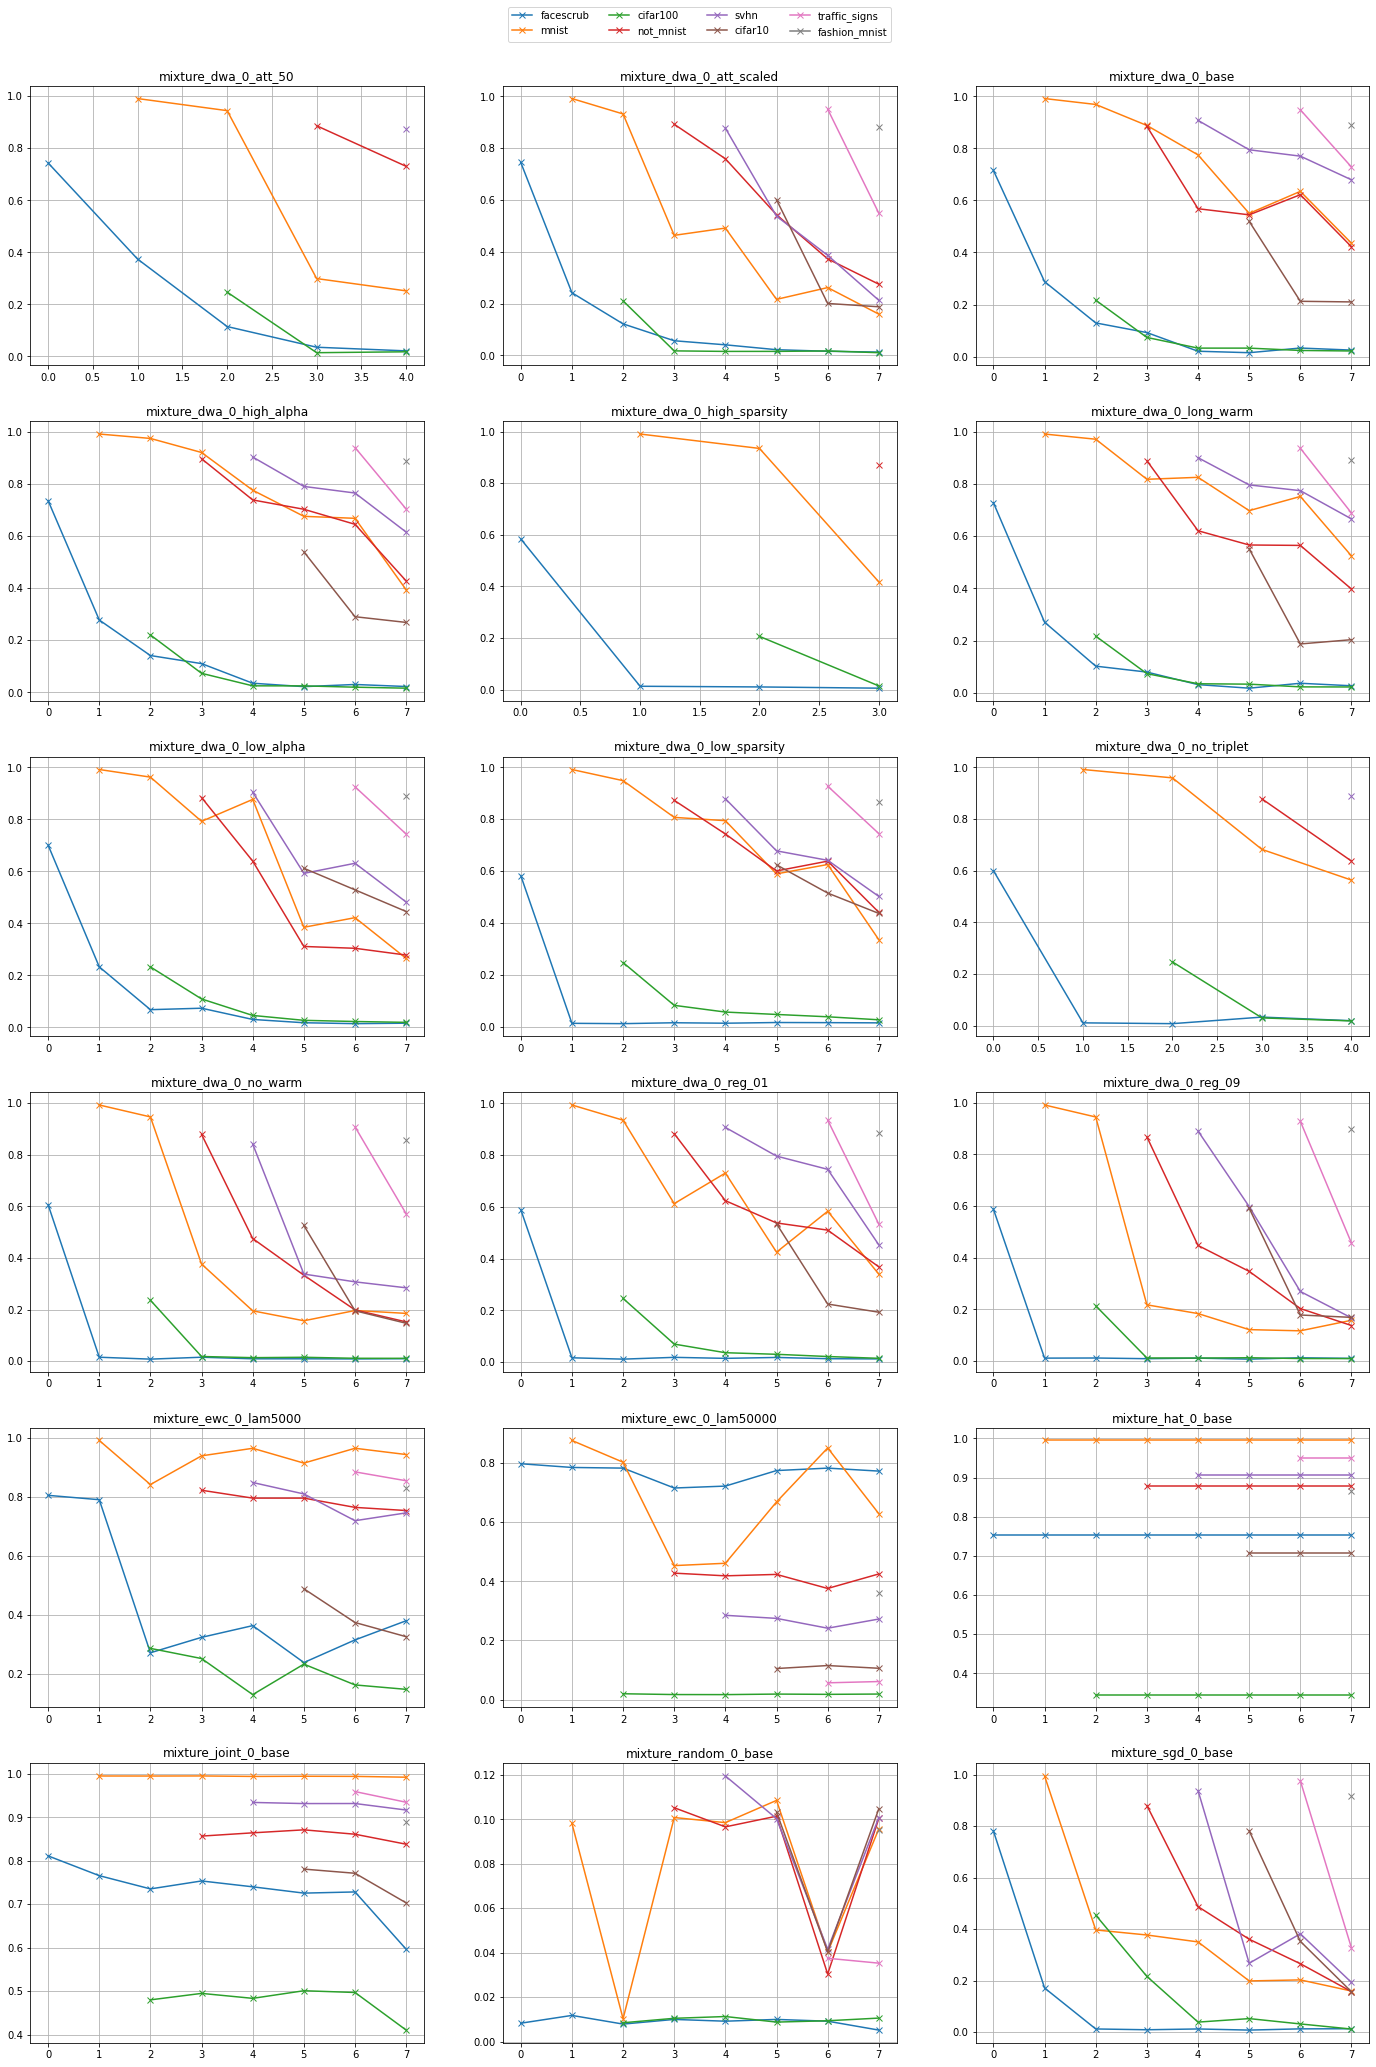

In [158]:
# Plot outcomes
rows = 3
cols = int(np.ceil(len(exp_map) / rows))
fig, axs = plt.subplots(cols, rows, figsize=(8 * rows, 6 * cols))
pos = 0
fltaxs = axs.flatten()
for exp in exp_map:
    ax = fltaxs[pos]
    pos += 1

    results[exp].replace(0, np.NaN).plot.line(marker="x", title=exp_map[exp], ax=ax, legend=None, grid=True)
        
# generate labels and plot
fltaxs[min(rows // 2, len(exp_map) -1)].legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=4)
plt.show()

### Forgetting Ratios

The forgetting ratio is defined as TODO

c:\code\envs\research\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\code\envs\research\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\code\envs\research\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


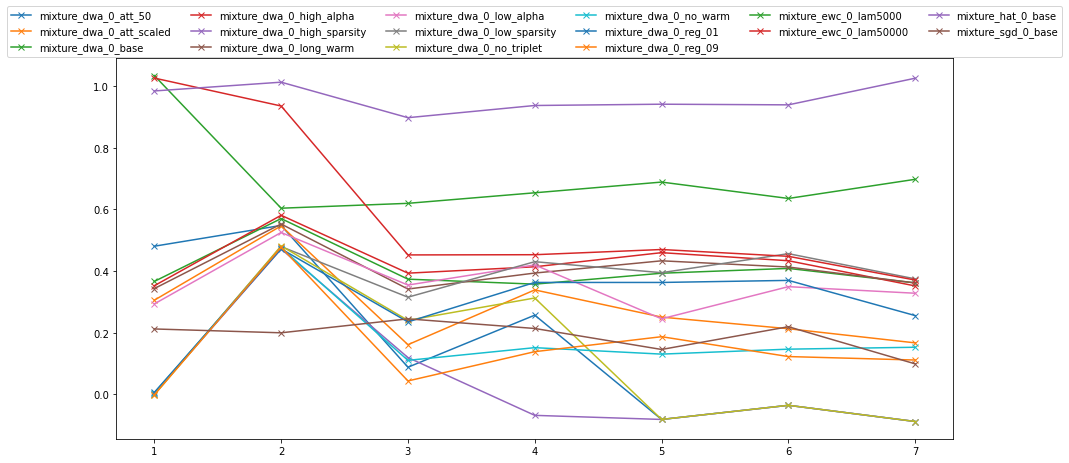

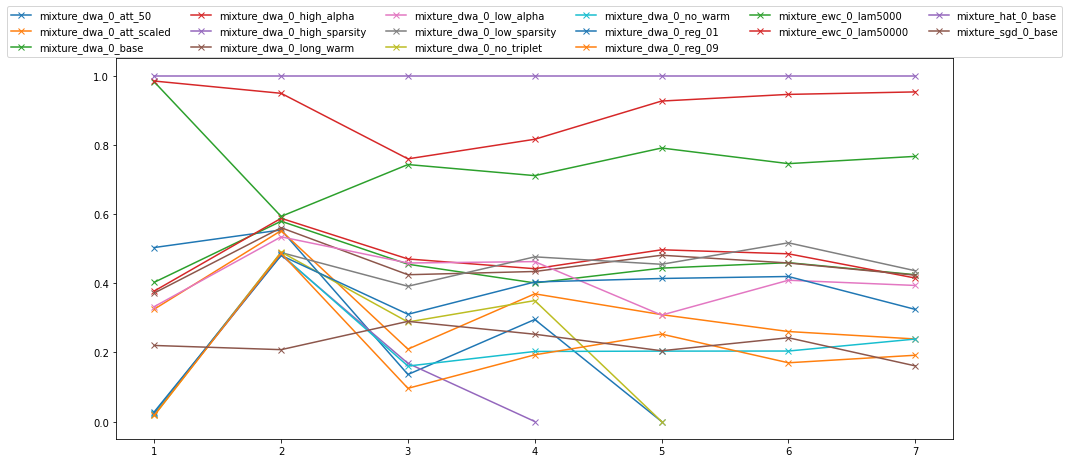

In [159]:
# TODO: compute forget ratio for each approach after each task (then combine)
rand = results["mixture_random_0_base"]
joint = results["mixture_joint_0_base"]
forget_ratio = {}
simple_forget_ratio = {}

for exp in exp_map:
    if exp in ["mixture_joint_0_base", "mixture_random_0_base"]: continue
    data = results[exp]
    
    # compute the forget ratio
    fr = []
    sfr = []
    for train_id in range(data.shape[0]):
        prec = data.iloc[train_id, :train_id]
        rand_prec = rand.iloc[train_id, :train_id]
        join_prec = joint.iloc[train_id, :train_id]
        out = ((prec - rand_prec) / (join_prec - rand_prec)).mean()
        fr.append(out)
        
        task_fr = []
        for task_id in range(train_id):
            task_fr.append((data.iloc[train_id, task_id] / data.iloc[task_id, task_id]))
        sfr.append(np.mean(task_fr))
    forget_ratio[exp] = fr
    simple_forget_ratio[exp] = sfr
forget_ratio = pd.DataFrame(forget_ratio)
simple_forget_ratio = pd.DataFrame(simple_forget_ratio)
    
# gemerate resulting plot
fig, ax = plt.subplots(1, figsize=(15, 7))
forget_ratio.iloc[1:, :].plot.line(marker='x', ax=ax)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=6)
plt.show()

fig, ax = plt.subplots(1, figsize=(15, 7))
simple_forget_ratio.iloc[1:, :].plot.line(marker='x', ax=ax)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=6)
plt.show()

### Losses

Plot losses for each approach

In [81]:
def convert_feat(logs, name):
    res = {}
    data = logs[name]
    names = data["task_name"]
    for key in data:
        items = data[key]
        if key == "task_name":
            continue
        dfs = []
        for i in range(len(items)):
            cdf = pd.DataFrame(items[i])
            cdf = cdf.reset_index()
            cdf["ep"] = names[i]
            cdf = cdf.set_index(["ep", "index"])
            dfs.append(cdf)
        df = pd.concat(dfs)
        df.columns = [name]
        res[key] = df
    return res

df_logs = convert_feat(logs, "mixture_dwa_0_no_comb")

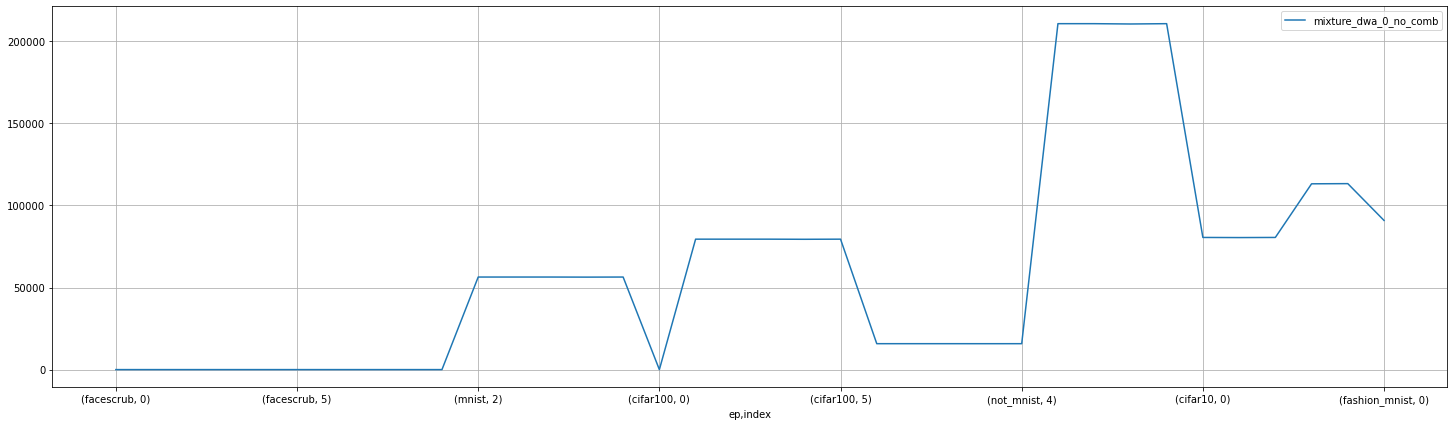

In [99]:
df_logs["test_triplet"].plot(figsize=(25, 7), grid=True)

### Analysis

Display the attention masks at the end of training through the different tasks

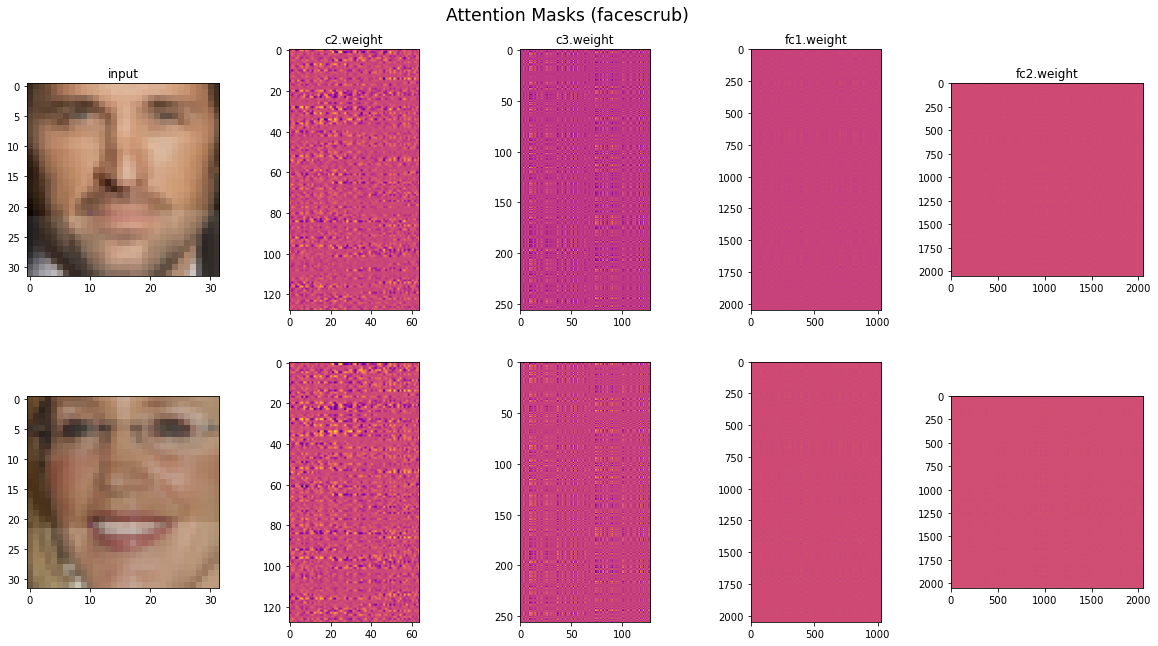

In [152]:
def show_masks(exp, task, max_imgs=2):
    task_data = analysis[exp][task]

    # display iamges and masks
    imgs = task_data["images"]
    masks = task_data["masks"]
    cols = len(masks) + 1
    rows = min(len(imgs), max_imgs)
    fig, axes = plt.subplots(nrows=rows, ncols=cols, sharex=False, sharey=False, figsize=(20,5*rows)) 
    fig.suptitle("Attention Masks ({})".format(task), fontsize='xx-large')
    fig.subplots_adjust(top=0.92) 

    for i in range(rows):
        # display the iamge
        ax = axes[i, 0]
        #img = (np.transpose(imgs[i], (1, 2, 0)) + 5) / 10
        img = (np.reshape(imgs[i], (32, 32, 3)) + 2.5) / 5
        #img = resize(img, (256, 256))
        ax.imshow(img)

        # go through masks
        for j, key in enumerate(masks):
            ax = axes[i, j + 1]
            mask = masks[key][i]
            if len(mask.shape) > 2:
                #mask = np.reshape(mask, (mask.shape[0] * mask.shape[2], mask.shape[1] * mask.shape[3]))
                mask = np.mean(mask, axis=(-2, -1))
            ax.imshow(mask, cmap='plasma')
    axes[0, 0].set_title("input")
    for j, key in enumerate(masks):
        axes[0, j + 1].set_title(key)
    
    plt.show()
    
# display the masks for a single experiment task
show_masks('mixture_dwa_0', "facescrub")

Display the embedding vectors for the different tasks

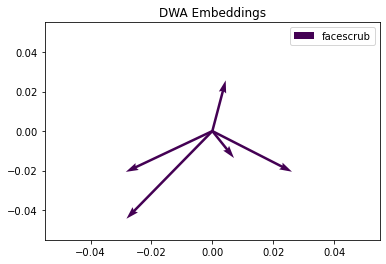

In [151]:
from sklearn.decomposition import PCA
    
def display_vectors(exp, max_emb=2):
    # collect the data
    data = analysis[exp]
    names = list(data.keys())
    data = [data[key]["emb"] for key in data]
    
    # define reduction
    pca = PCA(2)
    all_embs = np.concatenate(data, axis=0)
    pca.fit(all_embs)
    
    # create the plot
    cmap = plt.cm.get_cmap('viridis', len(names))
    for i in range(len(names)):
        embs = data[i][:max_emb]
        embs = pca.transform(embs)
        
        origin = [0] * embs.shape[0], [0] * embs.shape[0]
        plt.quiver(*origin, embs[:,0], embs[:,1], color=cmap(i), scale=3, label=names[i])
    plt.legend()
    plt.title("DWA Embeddings")
    plt.show()

# TODO: maybe swtich to scatter plot if not working
# display embeddings for a single experiment (one color per task)
display_vectors("mixture_dwa_0", 5)